### Setup Environment

In [2]:
import pathlib, os
import datetime

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### The Auto MPG Dataset
*Shamelessly borrowed from google's example for regression, writte by François Chollet, author of Deep Learnig with Python<br>
<br>
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ttariksetia/3pg-cop-dnn/blob/master/regression.ipynb)

In [109]:
# Download Dataset
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

In [4]:
# Path
dataset_path

'/Users/tarik.setia/.keras/datasets/auto-mpg.data'

#### Import data into Pandas

In [5]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


#### Clean The Dataset

In [6]:

dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [7]:
dataset = dataset.dropna()

The "Origin" column is really categorical, not numeric. So convert that to a one-hot:

In [8]:
origin = dataset.pop('Origin')

In [9]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [10]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [11]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [12]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

#### Normalization or Data Scaling

It is good practice to normalize features that use different scales and ranges. Although the model might converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

In [13]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

In [14]:
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

#### Modelling

##### Build The Model

In [93]:
keras.backend.clear_session()

In [94]:
input_shape = [len(train_dataset.keys())]
model = keras.Sequential()
model.add(layers.Dense(64, activation=tf.nn.relu, input_shape=input_shape))
model.add(layers.Dense(64, activation=tf.nn.relu))
model.add(layers.Dense(1))

In [95]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [96]:
model.layers[0].weights

[<tf.Variable 'dense/kernel:0' shape=(9, 64) dtype=float32, numpy=
 array([[ 0.12745306, -0.20249951, -0.23590034, -0.08433336,  0.01341984,
         -0.07301106,  0.02326357,  0.27705982,  0.18110955, -0.02006078,
          0.21929207, -0.03517815, -0.1927549 ,  0.03672013, -0.09653407,
          0.06004453, -0.0104813 ,  0.23974231, -0.10854088, -0.22705841,
         -0.15583375, -0.07702368,  0.13368332, -0.15772322, -0.18502027,
         -0.21743685, -0.12985756,  0.03053448,  0.00694105, -0.11449814,
          0.00786251,  0.07551596, -0.251015  , -0.1911741 ,  0.06123215,
         -0.00904816,  0.1712611 , -0.2740897 ,  0.2463744 ,  0.15916553,
          0.19038007, -0.19677067,  0.15238947,  0.22301295,  0.03284433,
          0.1980021 , -0.2676081 , -0.12367487,  0.18059602, -0.16067708,
          0.06465003, -0.21212107, -0.05466975,  0.25144908, -0.22097182,
          0.07272241,  0.1079534 ,  0.16327584,  0.194938  , -0.2840129 ,
         -0.04426746,  0.13596621, -0.2236615

##### Let us try to make prediction on this untrained model
Take a batch of 10 examples from the training data and call model.predict on it.

In [97]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.7754645 ],
       [-0.53150856],
       [ 0.14294146],
       [-0.9744833 ],
       [-0.98355955],
       [-0.2179513 ],
       [-1.0799592 ],
       [-0.97448826],
       [-0.04965307],
       [-1.0112929 ]], dtype=float32)

# [!Back to Slide](https://docs.google.com/presentation/d/19xm7i_UvxSBtRbxTI9DCdRsJ2vKoL9p4hiRq4vgJ3q8/edit#slide=id.g62c5f47c05_4_13)

In [98]:
list(filter(lambda x: "_" not in x, dir(keras.losses)))

['BinaryCrossentropy',
 'CategoricalCrossentropy',
 'CategoricalHinge',
 'CosineSimilarity',
 'Hinge',
 'Huber',
 'KLD',
 'KLDivergence',
 'LogCosh',
 'Loss',
 'MAE',
 'MAPE',
 'MSE',
 'MSLE',
 'MeanAbsoluteError',
 'MeanAbsolutePercentageError',
 'MeanSquaredError',
 'MeanSquaredLogarithmicError',
 'Poisson',
 'Reduction',
 'SparseCategoricalCrossentropy',
 'SquaredHinge',
 'deserialize',
 'get',
 'hinge',
 'kld',
 'logcosh',
 'mae',
 'mape',
 'mse',
 'msle',
 'poisson',
 'serialize']

In [99]:
list(filter(lambda x: "_" not in x, dir(keras.optimizers)))

['Adadelta',
 'Adagrad',
 'Adam',
 'Adamax',
 'Ftrl',
 'Nadam',
 'Optimizer',
 'RMSprop',
 'SGD',
 'deserialize',
 'get',
 'schedules',
 'serialize']

In [100]:
optimizer = tf.keras.optimizers.RMSprop(0.001)

In [101]:
model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])

In [102]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')
    
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [103]:
EPOCHS = 50

In [104]:
history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot(), tensorboard_callback])


..................................................

Visualize the model's training progress using the stats stored in the history object.



In [105]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
45,7.095396,1.911750,7.095396,8.373540,2.204605,8.373540,45
46,7.154440,1.910376,7.154440,8.552183,2.196117,8.552184,46
47,7.153687,1.928695,7.153687,8.726362,2.207462,8.726362,47
48,7.016494,1.910855,7.016494,8.613849,2.174714,8.613849,48
49,7.066881,1.929026,7.066882,8.480313,2.263385,8.480312,49


In [106]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

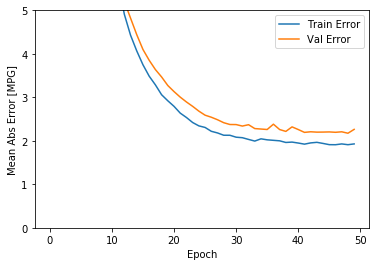

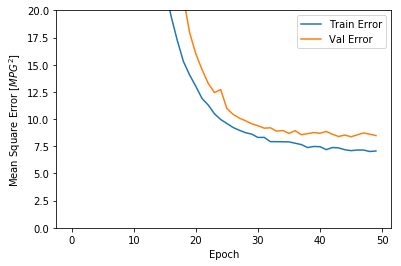

In [107]:
plot_history(history)

### Make Predictions!!
Predict MPG values for Test data set

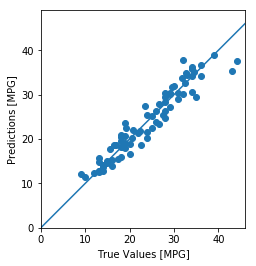

In [108]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])